In [1]:
# 0) 基础库
import numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

DATA_DIR = Path(".")
RED  = DATA_DIR / "winequality-red.csv"
WHITE= DATA_DIR / "winequality-white.csv"
print("数据文件存在性：", RED.exists(), WHITE.exists())

数据文件存在性： True True


In [2]:
# 1) 读取数据
USE = "red"  

def load_wine(which="red"):
    if which == "both":
        dfs = []
        if RED.exists():
            dfs.append(pd.read_csv(RED, sep=";").assign(color=0))
        if WHITE.exists():
            dfs.append(pd.read_csv(WHITE, sep=";").assign(color=1))
        if not dfs:
            raise FileNotFoundError("未找到 red/white 任一数据文件。请将 CSV 放至同目录。")
        return pd.concat(dfs, ignore_index=True)
    elif which == "red":
        if not RED.exists():
            raise FileNotFoundError("未找到 winequality-red.csv，请放至同目录。")
        return pd.read_csv(RED, sep=";").assign(color=0)
    else:
        if not WHITE.exists():
            raise FileNotFoundError("未找到 winequality-white.csv，请放至同目录。")
        return pd.read_csv(WHITE, sep=";").assign(color=1)

df = load_wine(USE)
print(df.shape)
df.head()

(1599, 13)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  color  
0      9.4        5      0  
1      9.8        5      0  
2      9.8        5      0  
3      9.8        6      0  
4      9.4        5      0

In [7]:
# 2) 清洗：5σ 过滤极端值 + 标准化 + 标签编码(从0开始)
def sigma_filter(df, cols, z=5.0):
    d = df.copy()
    for c in cols:
        mu, sd = d[c].mean(), d[c].std(ddof=0)
        if sd > 0:
            d = d[(d[c] >= mu - z * sd) & (d[c] <= mu + z * sd)]
    return d


feature_cols = [c for c in df.columns if c not in ["quality"]]
df_clean = sigma_filter(df, feature_cols, z=5.0)
print("过滤前/后：", df.shape, "->", df_clean.shape)

# === 关键：把原始 quality(3~9) 编码为 0..K-1 ===
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df_clean["quality"].values)  
print("原始质量标签：", list(le.classes_)) 
num_classes = len(le.classes_)

# 特征与划分/标准化
X = df_clean.drop(columns=["quality"]).values
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 类别权重（注意用编码后的 y_train）
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)  # 现在是 [0..K-1]
class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight_dict = {int(c): w for c, w in zip(classes, class_weights)}
print("类别权重：", class_weight_dict)

过滤前/后： (1599, 13) -> (1556, 13)
原始质量标签： [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
类别权重： {0: np.float64(29.61904761904762), 1: np.float64(5.056910569105691), 2: np.float64(0.39342188488298546), 3: np.float64(0.41633199464524767), 4: np.float64(1.3205944798301485), 5: np.float64(14.80952380952381)}


In [8]:
# 3A) 决策树 + 网格搜索
dt = DecisionTreeClassifier(random_state=42)
param_dt = {
    "max_depth":[None,5,10,15,20],
    "min_samples_leaf":[1,3,5,10]
}
grid_dt = GridSearchCV(dt, param_dt, cv=5, n_jobs=-1, scoring="accuracy")
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print("最佳决策树：", best_dt)

pred_dt = best_dt.predict(X_test)
acc_dt  = accuracy_score(y_test, pred_dt)
f1_dt   = f1_score(y_test, pred_dt, average="macro")
print("DT Accuracy/MacroF1:", acc_dt, f1_dt)

最佳决策树： DecisionTreeClassifier(max_depth=5, random_state=42)
DT Accuracy/MacroF1: 0.5512820512820513 0.2271220842649414


In [ ]:
# 3B) 逻辑回归 + 网格搜索
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

lr = LogisticRegression(max_iter=2000, solver="lbfgs")  # 不要再传 multi_class
param_lr = {
    "C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "class_weight": [None, "balanced"],  
}

grid_lr = GridSearchCV(lr, param_lr, cv=5, n_jobs=-1, scoring="accuracy")
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
pred_lr = best_lr.predict(X_test)
acc_lr  = accuracy_score(y_test, pred_lr)
f1_lr   = f1_score(y_test, pred_lr, average="macro", zero_division=0)
print("最佳逻辑回归：", best_lr)
print("LR Accuracy/MacroF1:", acc_lr, f1_lr)


最佳逻辑回归： LogisticRegression(C=0.5, max_iter=2000, multi_class='multinomial',
                   solver='saga')
LR Accuracy/MacroF1: 0.625 0.30971357761267626


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [10]:
# 3C) 神经网络 + 早停
num_classes = len(np.unique(y_train))

def build_nn(width=64, depth=2, dropout=0.2, lr=1e-3, input_dim=None, num_classes=None):
    m = keras.Sequential([layers.Input(shape=(input_dim,))])
    for _ in range(depth):
        m.add(layers.Dense(width, activation="relu"))
        if dropout>0: m.add(layers.Dropout(dropout))
    m.add(layers.Dense(num_classes, activation="softmax"))
    m.compile(optimizer=keras.optimizers.Adam(lr),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

nn = build_nn(width=64, depth=2, dropout=0.2, lr=1e-3, input_dim=X_train.shape[1], num_classes=num_classes)
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("ann2_best.keras", monitor="val_loss", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
]

hist = nn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=0
)
loss_nn, acc_nn = nn.evaluate(X_test, y_test, verbose=0)
pred_nn = nn.predict(X_test, verbose=0).argmax(axis=1)
f1_nn = f1_score(y_test, pred_nn, average="macro")
print("NN Accuracy/MacroF1:", acc_nn, f1_nn)

NN Accuracy/MacroF1: 0.46794870495796204 0.3117114927595984


In [11]:
# 4) 对比表 + 可解释性（系数/特征重要度）
res = pd.DataFrame({
    "Model":["DecisionTree","LogisticRegression","NeuralNetwork"],
    "Accuracy":[acc_dt, acc_lr, acc_nn],
    "MacroF1":[f1_dt, f1_lr, f1_nn]
}).sort_values("Accuracy", ascending=False)
res

Model  Accuracy   MacroF1
1  LogisticRegression  0.625000  0.309714
0        DecisionTree  0.551282  0.227122
2       NeuralNetwork  0.467949  0.311711

In [12]:
# 逻辑回归：系数（按绝对值排序展示 Top-10）
if hasattr(best_lr, "coef_"):
    import numpy as np
    coef = np.abs(best_lr.coef_).mean(axis=0)  # 多分类取均值
    names = [c for c in df_clean.drop(columns=["quality"]).columns]
    order = np.argsort(coef)[::-1][:10]
    top_lr = pd.DataFrame({"feature":[names[i] for i in order], "abs_coef":coef[order]})
    print(top_lr)
else:
    print("逻辑回归未提供系数。")

                feature  abs_coef
0               alcohol  0.672945
1             sulphates  0.419623
2               density  0.412350
3      volatile acidity  0.401834
4  total sulfur dioxide  0.354930
5                    pH  0.353247
6         fixed acidity  0.317805
7             chlorides  0.232842
8        residual sugar  0.171368
9   free sulfur dioxide  0.169026


In [13]:
# 决策树：特征重要度（Top-10）
if hasattr(best_dt, "feature_importances_"):
    imp = best_dt.feature_importances_
    names = [c for c in df_clean.drop(columns=["quality"]).columns]
    order = np.argsort(imp)[::-1][:10]
    top_dt = pd.DataFrame({"feature":[names[i] for i in order], "importance":imp[order]})
    print(top_dt)
else:
    print("决策树未提供特征重要度。")

                feature  importance
0               alcohol    0.404745
1  total sulfur dioxide    0.165227
2             sulphates    0.161313
3      volatile acidity    0.119136
4               density    0.041550
5         fixed acidity    0.034357
6                    pH    0.026380
7        residual sugar    0.022114
8   free sulfur dioxide    0.013537
9             chlorides    0.007484


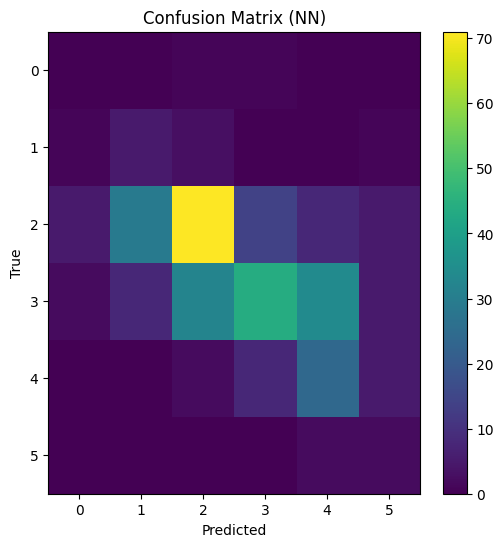

In [14]:
# 5) 混淆矩阵绘制（以 NN 为例，其他模型可同理）
cm = confusion_matrix(y_test, pred_nn)
plt.figure(figsize=(6,6))
plt.imshow(cm, aspect="auto")
plt.title("Confusion Matrix (NN)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()